<img src='http://www-scf.usc.edu/~ghasemig/images/sharif.png' alt="SUT logo" width=300 height=300 align=left class="saturate" >

<br>
<font>
<div dir=ltr align=center>
<font color=0F5298 size=7>
    Artificial Intelligence <br>
<font color=2565AE size=5>
    Computer Engineering Department <br>
    Fall 2023<br>
<font color=3C99D size=5>
    Practical Assignment 5 - Machine Learning <br>
<font color=696880 size=4>
    Ali Sharifi


____

# Personal Data

In [5]:
# Set your student number
student_number = ''
Name = 'Ali'
Last_Name = 'Rahimi'

## Imports

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
rng = np.random.default_rng(42)

# Question 1: Polynomial Regresrion Implementation (15 points)

<font size=4>
Author: Ali Sharifi
<br/>
<font color=red>
Please run all the cells.
</font>
</font>
<br/>
</div>

In the following section, you will implement a class that performs Polynomial Regression. Follow instructions in the methods' body. Note that your input and output shapes must be the same as instructions.
$$\hat{y} = a_nx^n + \dots + a_1x + a_0$$

In [7]:
class PolynomialRegression:
    """
        The class of polynomial regression.
    """
    def __init__(self, degree):
        """
          initialize parameters you need.
        """
        self.degree = degree
        self.coefficients = None

    @staticmethod
    def PolynomialFeature(X, degree):
        """
          X of the shape (m, 1)
          returns an array A=(a_{ij}) of the shape (m, degree) such that a_{ij} = X_i^j
        """
        X_poly = np.ones((len(X), degree + 1))
        for i in range(1, degree + 1):
            X_poly[:, i] = X ** i
        return X_poly

    @staticmethod
    def LinearRegression(X, Y):
        """
          X of the shape (m, n)
          y of the shape (m,)
          returns coefficients of linear regression of the shape (n+1,) (extra coefficient for bias term)
        """
        alpha=1e-5
        cond_number = np.linalg.cond(X.T.dot(X))
        if cond_number > 1:
            theta_best = np.linalg.pinv(X.T.dot(X) + alpha * np.eye(X.shape[1])).dot(X.T).dot(Y)
        else:
            theta_best = np.linalg.inv(X.T.dot(X) + alpha * np.eye(X.shape[1])).dot(X.T).dot(Y)

        return theta_best


    def fit(self, X, Y):
        """
          X of the shape (m, n)
          y of the shape (m,)
          returns None
        """
        X_poly = self.PolynomialFeature(X, self.degree)
        self.coefficients = self.LinearRegression(X_poly, Y)

    def predict(self, X):
        """
          X of the shape (m, 1)
          returns an array of the shape (m,)
        """
        X_poly = self.PolynomialFeature(X, self.degree)
        return X_poly.dot(self.coefficients)


# Question 2: Regressing a Sine Function in Polyomial Functions (10 points)

Consider the underlying function $f^*(X) = \sin(X)$. Generate 15 datasets with 5, 10, 15, 25, and 50 i.i.d samples from the following distribution: (three datasets with each size)
$$
X \sim \text{uniform}(0, 2\pi) \\
Y | X \sim \text{N}(f^*(X), \sigma^2) \\
\text{where } \sigma = .5
$$
Assume we want to train models of degrees 1, 3, 8, 12, and 15 on these datasets. Generate a $5\times 5$ grid of plots. Assume that rows correspond to the dataset size and columns correspond to the degree of model. In each plot, plot the result hypothesis functions from training the corresponding model on the corresponding datasets. In addition plot the underlying function.

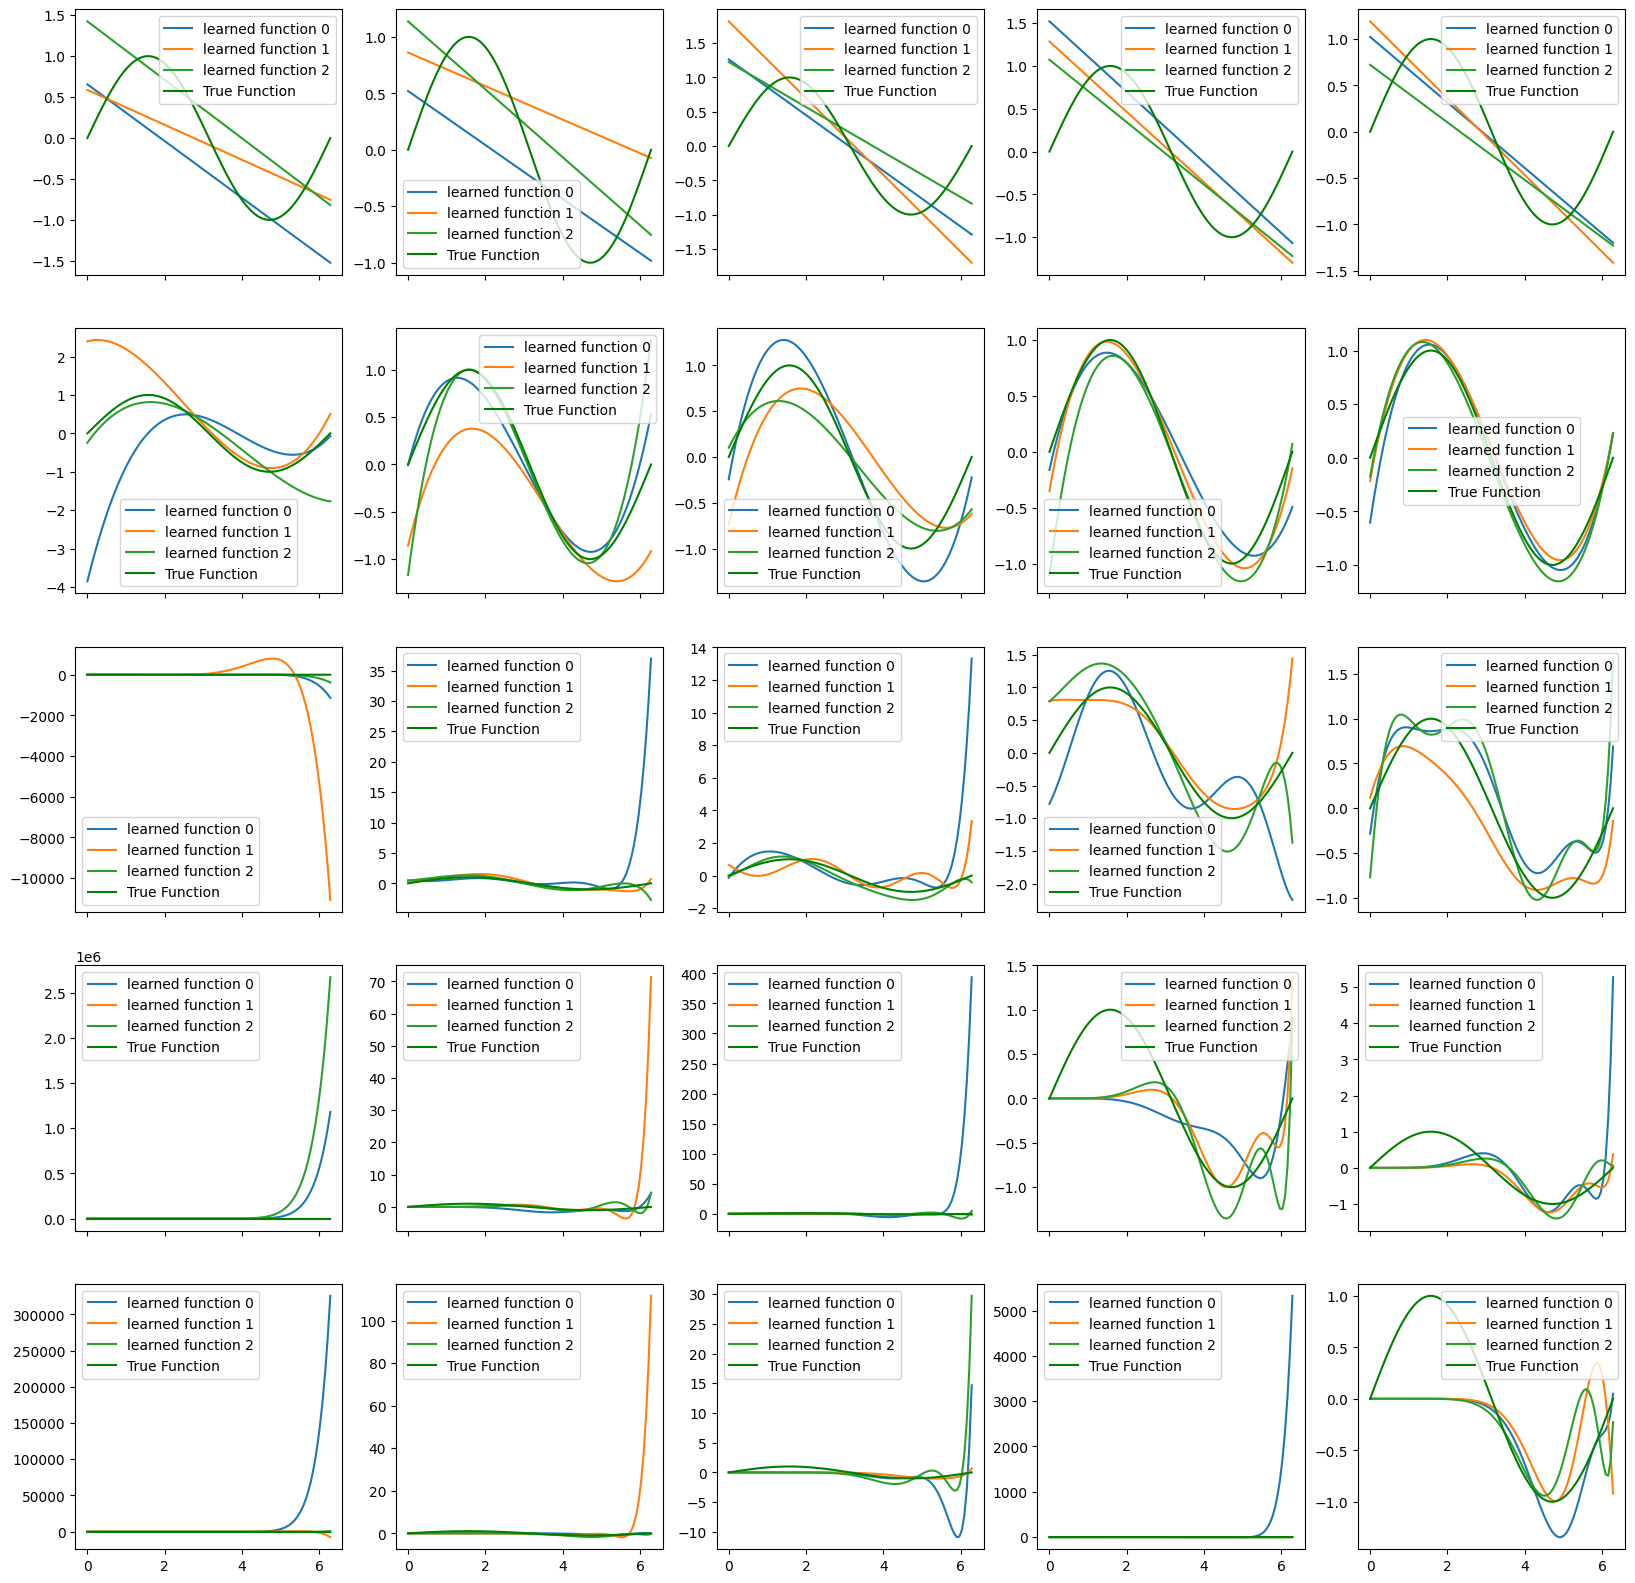

In [8]:
fig, ax = plt.subplots(5, 5, sharex=True, gridspec_kw=dict(hspace=.2, wspace=.2), figsize=(20, 20))
sample_sizes = [5, 10, 15, 25, 50]
degrees = [1, 3, 8, 12, 15]

for i, size in enumerate(sample_sizes):
    for j, degree in enumerate(degrees):
        for kk in range(3):
            X = rng.uniform(0, 2*np.pi, size)
            Y = np.sin(X) + rng.normal(0, 0.5, size)

            model = PolynomialRegression(degree)
            model.fit(X, Y)
            X_test = np.linspace(0, 2*np.pi, 100)
            Y_pred = model.predict(X_test)
            ax[j, i].plot(X_test, Y_pred, label=f'learned function {kk}')
        ax[j, i].plot(X_test, np.sin(X_test), label='True Function', color='green')
        ax[j, i].legend()

plt.show()


Which models are more sensitive to the "noise"? (i.e. If you sample many datasets with the same size and from the same distributions, the trained models on these datasets are very different.) How does the performance of each model change as the number of training samples increase? Does the performace of the linear model improve as the number of samples increase? How about the model of degree 15?

Models with higher degrees are more sensitive to noise. This is because they have more flexibility and can fit the random fluctuations or noise more closely. The models with higher variance with different datasets in same size are more sensitive to noise. This is happening in high degree polynomials.

As the number of training samples increases, the perfomance should improve. More data causes a better approximation for the real distribution. Even though in some of the plots the approximatation is still bad, but it is better than the plots with fewer number of training samples.

As the number of training samples increases, the perfomance of linear model increases, but only to a point. A linear model can only find linear relationships in good way, so while more data will help it estimate the best possible linear fit, it will never estimate the real sine function. At the best situation, it can converge to a straight line that has the best approximitaion for sine function.

In model of degree 15, with small number of samples, the model is likely to fit the noise better that the real function, So it is overfitting. As the number of samples increases, the model fits the data better. But since it has high flexivility, it still has high variance and overfits. With even more data, we can still improve the model, but it will still have the overfitting.

# Question 3: Estimating Bias-Variance Trade-off and Drawing Heatmaps (25 points)

## Estmate Bias-Variance Trade-off (20 points)

In this section, you will approximate bias and variance in different classes of polynomial regression models and then find relations between these quantities and n_train_samples and degree.

In [9]:
def bias_variance_estimation(degree, n_train_samples, n_trials=100):
    """
    This function estimates bias and variance of the hypothesis space of polynomials of degree at most d.
    You must perform n_trials, each consists of generating a training set of n_train_samples samples.
    Then you can compute the mean hypothesis and compute bias and variance.
    """
    X_test = np.linspace(0, 2*np.pi, 100)
    predictions = np.zeros((n_trials, len(X_test)))

    for i in range(n_trials):
        X = rng.uniform(0, 2*np.pi, n_train_samples)
        Y = np.sin(X) + rng.normal(0, 0.5, n_train_samples)
        model = PolynomialRegression(degree)
        model.fit(X, Y)
        predictions[i] = model.predict(X_test)

    mean_prediction = np.mean(predictions, axis=0)

    true_function = np.sin(X_test)
    bias = np.mean((mean_prediction - true_function)**2)
    variance = np.mean(np.var(predictions, axis=0))

    return bias, variance


## Drawing Heatmaps (5 points)

Now, estimate bias and variance for a model of degree $d$ trained on $n$ samples for values of $d$ and $n$ in the previous section. Then show the results for bias and variance separately as heat maps. (If values of bias and variance are very large, you can use a logarithmic scale.)

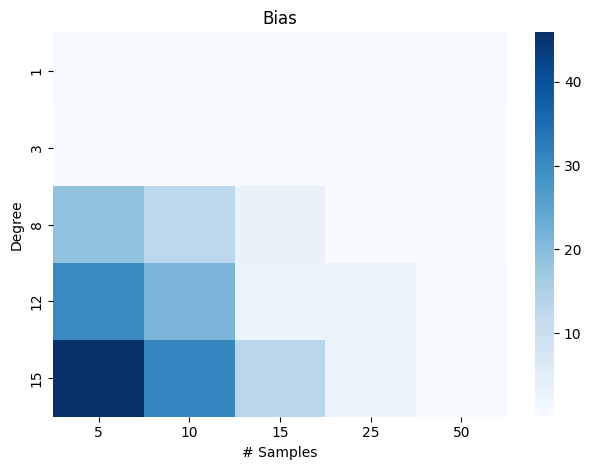

In [10]:
bias_values = np.zeros((len(degrees), len(sample_sizes)))
variance_values = np.zeros((len(degrees), len(sample_sizes)))

for i, degree in enumerate(degrees):
    for j, size in enumerate(sample_sizes):
        bias, variance = bias_variance_estimation(degree, size)
        bias_values[i, j] = bias
        variance_values[i, j] = variance

sns.heatmap(np.log1p(bias_values), annot=False, xticklabels=sample_sizes, yticklabels=degrees, cmap='Blues')
plt.title('Bias')
plt.xlabel('# Samples')
plt.ylabel('Degree')
plt.tight_layout()
plt.show()


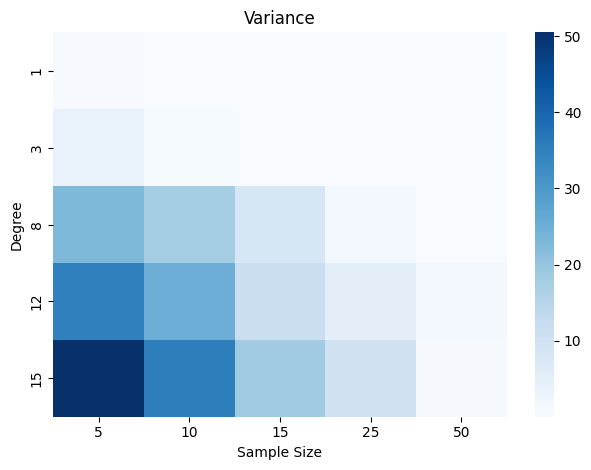

In [11]:
sns.heatmap(np.log1p(variance_values), annot=False, xticklabels=sample_sizes, yticklabels=degrees, cmap='Blues')
plt.title('Variance')
plt.xlabel('Sample Size')
plt.ylabel('Degree')
plt.tight_layout()
plt.show()

Fixing the `degree`, how does bias (or variance) change as the `n_train_samples` increase? Similarly, fixing the `n_train_samples`, how does bias (or variance) change as the `degree` increase? Assume that you have a large dataset. Do you prefer to use a "complex" model or a "simple" model? Why?


Fixing the degree, as the number of training samples increases, bias and variance decrease (the bias of linear model decreases very slowly and almost stays the same). This is because have more data causes better estimation, so model can predict better.

Fixing the train samples, increasing the degree of the polynomial causes to an increase in variance. It almost causes to a decrease in bias (decrease in some points that I'll explain in the rest of the answer and increase in other points). For the linear model, lower degrees may not fit the data well, resulting in higher bias. So the bias of 1 degree is more than 3 and 8 degrees in larger sample sizes. This can also happen in larger degrees and larger sample sizes (for example in 12 degree has more bias than 15 degrees in 50 sample size).

Having a large dataset, choosing between complex and simple model depends on the specific problem. Using a complex model makes more sense, if the true function is complex, So that more data can be used to train the model without overfitting. Using simpler model is better, if the true relationship is simple or we care about computation cost or the risk of overfitting. Finally, for choosing a good model we should consider the trade-off between bias and variance. We should choose a balance model that minimizes both bias and variance.
